In [40]:
# These values are set here and used further down
filename = "trace-Tue 26 Jul 10-57-38 BST 2022.h5"
# plot_frame = True
frame = 400 # Expected if plot_frame is True, alternatively use a timestamp
timestamp = 1658826552.89 # Expected in seconds UTC (Note: the data takes into consideration nanoseconds) Example: 1658826552.89
detector_to_plot = 0 # The value of the detector to plot

In [41]:
import h5py

data = h5py.File(filename, 'r')
detector_data = data['detector_data']
seconds_list = data['frame_timestamp']['seconds']
nanoseconds_list = data['frame_timestamp']['nanoseconds']
frame_list = data['frame_start_index']

# Ensure that the frame is set, and if not then try find it from the timestamp
if frame is None:
    if timestamp is None:
        raise Exception("If frame is None, timestamp needs to be given for the frame otherwise we can't determine the frame to output")
    else:
        # Work out the frame from the timestamp
        for index in range(0, len(seconds_list)-1):
            first = seconds_list[index] + nanoseconds_list[index] * 1e-9
            second = seconds_list[index+1] + nanoseconds_list[index+1] * 1e-9
            if first < timestamp <= second:
                frame = index
                break

if frame is None:
    raise Exception("Frame was not set, and the frame could not be found from input data")
frame

400

In [42]:
# Grab the frame's data
lower_limit = frame_list[frame]
upper_limit = frame_list[frame+1]
frame_data = detector_data[detector_to_plot][lower_limit:upper_limit]
frame_data

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

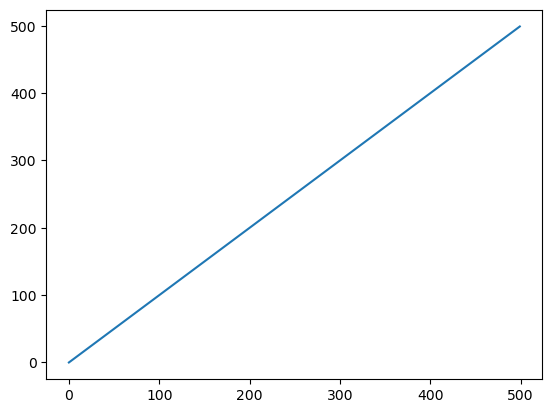

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(frame_data)